# ODE-Net used with real data

Now that we have tested the ODE-Net architecture on different small examples, we can test it on real data to see how it performs. 

The data whe chose is the MIT Beth Israel Hospital (BIH) electrocardiogram dataset that can be found at https://www.kaggle.com/shayanfazeli/heartbeat

This dataset consists of around 110,000 samples, classified as either 
- 0: normal;
- 1: supraventricular premature beat;
- 2: premature ventricular contraction;
- 3: fusion of ventricular and normal beat;
- 4: unclassified beat.

We will build a ResNet and an ODE-Net as similar as possible so that we can compare them better.

- The Resnet is composed of 3 first linear layers with ReLu as activation function, followed by 6 residual block also with ReLu. The output layer is a simple linear layer (with the input flattened).

- The ODE-Net is composed similarly of 3 first layers but this time convolutional, each followed by a normalization and the activation function ReLu. The dynamics are defined by ODEfunc, which is a convolutional layer with normalization. The output layer is the same as for the ResNet, i.e. a simple linear layer, except it has an adaptative average pool layer before the last linear layer.

To optimize our model we use the cross entropy error.

First we need to define some functions that we will use in our model constructors.

In [6]:
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import matplotlib.pyplot as plt


class ResBlock(nn.Module):
    """
    Residual block used to construct the ResNet
    """
    def __init__(self, dim):
        super(ResBlock, self).__init__()
        self.lin = nn.Linear(dim, dim, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.relu(x)
        out = self.lin(out)

        out += identity

        return out


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)

class ConcatConv1d(nn.Module):
    """
    1d convolution concatenated with time for usage in ODENet.
    """
    def __init__(self, dim_in, dim_out, kernel_size=3, stride=1, padding=0, bias=True, transpose=False):
        super(ConcatConv1d, self).__init__()
        module = nn.Conv1d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=kernel_size, stride=stride, padding=padding,
            bias=bias)

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)


class ODEfunc(nn.Module):
    """
    Function describing the dynamics of an ODE-Net
    """
    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv = ConcatConv1d(dim, dim, 3, 1, 1)

    def forward(self, t, x):
        out = self.norm(x)
        out = self.relu(out)
        out = self.conv(t, out)
        out = self.norm(out)
        return out


class Flatten(nn.Module):
    """
    Flatten feature maps to get inputs for a linear layer.
    """
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


def loss_batch(model, loss_func, xb, yb, opt=None):
    """
    Computes the loss and update the weights during training
    """
    loss = loss_func(model(xb.float()), yb.long())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

We can now create the architecture of our models.

In [7]:
class ODENet(nn.Module):
    """
    Class representing an ODE-Net using the dopri5 solver for ODEs.
    
    rtol : float
        relative tolerance of ODE solver
    atol : float
        absolute tolerance of ODE solver
    """
    def __init__(self, odefunc, rtol=1e-3, atol=1e-3):
        super(ODENet, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()
        self.rtol = rtol
        self.atol = atol

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint_adjoint(self.odefunc, y0=x, t=self.integration_time, rtol=self.rtol, atol=self.atol)
        return out[1]

def get_model(is_odenet=True, dim=64, **kwargs):
    """
    Initialize a ResNet or  an ODE-Net with optimizer
    """
    if is_odenet:
        downsampling_layers = [
        nn.Conv1d(1, dim, 3, 1),
        norm(dim),
        nn.ReLU(inplace=True),
        nn.Conv1d(dim, dim, 4, 2, 1),
        norm(dim),
        nn.ReLU(inplace=True),
        nn.Conv1d(dim, dim, 4, 2, 1)]

    else:
        downsampling_layers = [
            nn.Linear(187, dim),
            nn.ReLU(inplace=True),
            nn.Linear(dim, dim),
            nn.ReLU(inplace=True),
            nn.Linear(dim, dim)]

    feature_layers = [ODENet(ODEfunc(dim), **kwargs)] if is_odenet else [ResBlock(dim) for _ in range(6)]
    
    if is_odenet:
        fc_layers = [norm(dim), nn.ReLU(inplace=True), nn.AdaptiveAvgPool1d(1), Flatten(), nn.Linear(dim, 5)]
    else:
        fc_layers = [nn.ReLU(inplace=True), Flatten(), nn.Linear(dim, 5)]

    model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers)
    opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    return model, opt

The only thing left to do is to create our model and import the data to train them.

In [8]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    """
    Train a neural network model
    """
    num_batches = len(train_dl)
    train_error = []
    test_error = []

    for epoch in range(epochs):
        print(f"Epoch number {epoch + 1}")
        
        model.train()
        batch_count = 0
        for xb, yb in train_dl:
            batch_count += 1
            loss_batch(model, loss_func, xb, yb, opt)
            

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_error.append(val_loss)
        print(f"\n    Test error after {epoch + 1} epochs: {round(val_loss, 2)}\n")

        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl]
            )
        val_loss_train = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        train_error.append(val_loss_train)
    return train_error, test_error

mit_train = pd.read_csv('mitbih_train.csv', header=None)
mit_test = pd.read_csv('mitbih_test.csv', header=None)

y_train = mit_train[187]
X_train = mit_train.loc[:, :186]

y_test = mit_test[187]
X_test = mit_test.loc[:, :186]

X_train, y_train, X_test, y_test = map(torch.from_numpy, 
    (X_train.values, y_train.values, X_test.values, y_test.values))

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)


batch_size = 128

train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

Epoch number 1

    Test error after 1 epochs: 0.26

Epoch number 2

    Test error after 2 epochs: 0.19

Epoch number 3

    Test error after 3 epochs: 0.16

Epoch number 4

    Test error after 4 epochs: 0.15

Epoch number 5

    Test error after 5 epochs: 0.15

Epoch number 6

    Test error after 6 epochs: 0.13

Epoch number 7

    Test error after 7 epochs: 0.2

Epoch number 8

    Test error after 8 epochs: 0.13

Epoch number 9

    Test error after 9 epochs: 0.14

Epoch number 10

    Test error after 10 epochs: 0.12

Epoch number 11

    Test error after 11 epochs: 0.12

Epoch number 12

    Test error after 12 epochs: 0.11

Epoch number 13

    Test error after 13 epochs: 0.1

Epoch number 14

    Test error after 14 epochs: 0.11

Epoch number 15

    Test error after 15 epochs: 0.1

Epoch number 16

    Test error after 16 epochs: 0.1

Epoch number 17

    Test error after 17 epochs: 0.1

Epoch number 18

    Test error after 18 epochs: 0.1

Epoch number 19

    Test error af

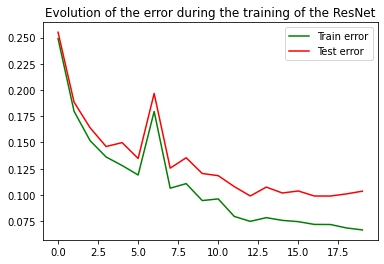

In [14]:
resnet, resopt = get_model(is_odenet=False)

train_error, test_error = fit(20, resnet, F.cross_entropy, resopt, train_dl, test_dl)

plt.plot(train_error, color='g', label='Train error')
plt.plot(test_error, color='r', label='Test error')
plt.title('Evolution of the error during the training of the ResNet')
plt.legend()
plt.show()

torch.save(resnet, "resnet.pt")

Epoch number 1

    Test error after 1 epochs: 0.47

Epoch number 2

    Test error after 2 epochs: 0.2

Epoch number 3

    Test error after 3 epochs: 0.15

Epoch number 4

    Test error after 4 epochs: 0.14

Epoch number 5

    Test error after 5 epochs: 0.11

Epoch number 6

    Test error after 6 epochs: 0.17

Epoch number 7

    Test error after 7 epochs: 0.09

Epoch number 8

    Test error after 8 epochs: 0.1

Epoch number 9

    Test error after 9 epochs: 0.08

Epoch number 10

    Test error after 10 epochs: 0.1



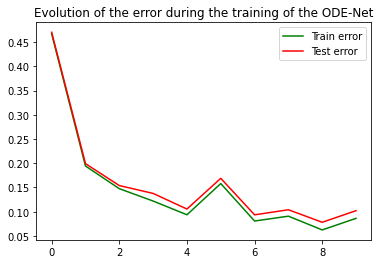

In [15]:
odenet, odeopt = get_model(rtol=1e-3, atol=1e-3)

train_error, test_error = fit(10, odenet, F.cross_entropy, odeopt, train_dl, test_dl)

plt.plot(train_error, color='g', label='Train error')
plt.plot(test_error, color='r', label='Test error')
plt.title('Evolution of the error during the training of the ODE-Net')
plt.legend()
plt.show()

torch.save(odenet, "odenet.pt")

To evaluate the accuracy of our models, we will use the softmax to get prediction for our test data, and then we use the zero-one loss to measure its accuracy.

In [ ]:
def accuracy(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        probs = model(X_test.float())
    preds = torch.argmax(F.softmax(probs, dim=1), axis=1).numpy()
    return (preds == y_test.numpy()).mean()

In [ ]:
print(f"ResNet accuracy: {round(accuracy(resnet, X_test, y_test), 3)}")
print(f"ODENet accuracy: {round(accuracy(odenet, X_test, y_test), 3)}")